In [34]:
from sklearn.svm import SVC

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

In [35]:
# Function to preprocess data (scaling and interaction features)
def preprocess_data(df, target_column, add_interactions=False):
    X = df.drop(columns=[target_column])
    Y = df[target_column]

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Rescale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for easier manipulation
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Add interaction features if needed
    if add_interactions and 'Fare' in X_train_scaled.columns and 'FamilySize' in X_train_scaled.columns:
        X_train_scaled['Fare_FamilySize'] = X_train_scaled['Fare'] * X_train_scaled['FamilySize']
        X_test_scaled['Fare_FamilySize'] = X_test_scaled['Fare'] * X_test_scaled['FamilySize']

    return X_train_scaled, X_test_scaled, Y_train, Y_test, scaler

# Function to train and evaluate models
def train_and_evaluate_models(X_train, Y_train, X_test, Y_test):
    models = {
        'Support Vector Machine': SVC(),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred) * 100
        results[name] = accuracy
        # Save the trained model
        joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')

    return results


In [36]:
# Function to preprocess new data
def preprocess_new_data(df, scaler, add_interactions=False):
    df_scaled = scaler.transform(df)

    # Convert back to DataFrame for easier manipulation
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Add interaction features if needed
    if add_interactions and 'Fare' in df_scaled.columns and 'FamilySize' in df_scaled.columns:
        df_scaled['Fare_FamilySize'] = df_scaled['Fare'] * df_scaled['FamilySize']

    return df_scaled

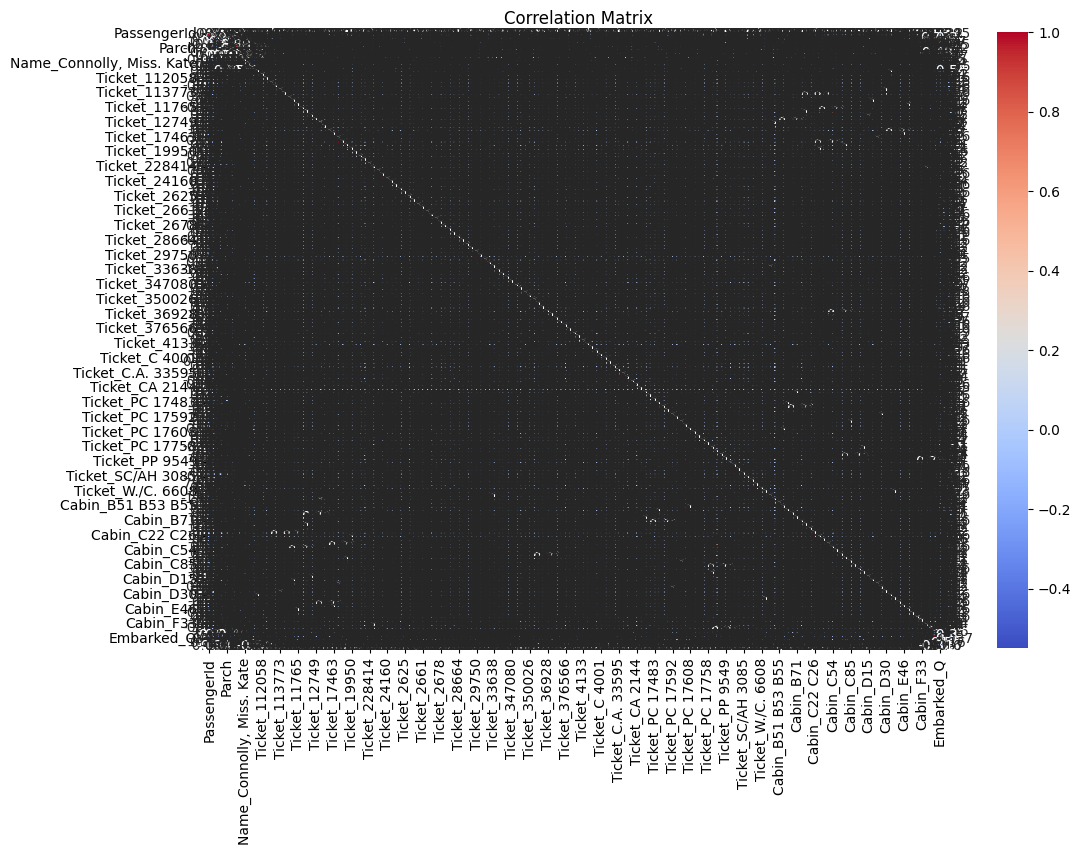

Model Performance:
 {'Support Vector Machine': 78.77094972067039, 'Random Forest': 84.35754189944134}


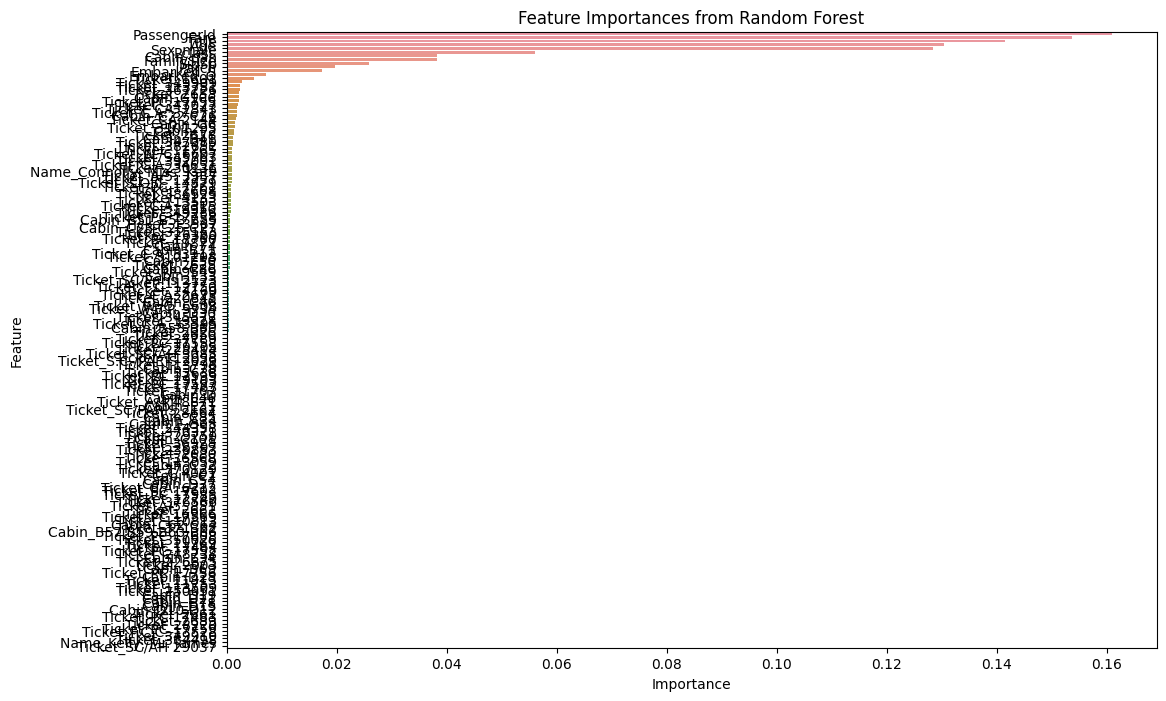

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300}
Cross-Validation Scores: [0.83216783 0.81818182 0.78169014 0.78873239 0.83802817]
Mean Cross-Validation Score: 0.8117600709150004


In [37]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
import lime.lime_tabular
import shap
import featuretools as ft

# Function to handle missing values
def handle_missing_values(df, strategy='mean'):
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if strategy == 'mean' and pd.api.types.is_numeric_dtype(df[column]):
                df.loc[:, column] = df[column].fillna(df[column].mean())
            elif strategy == 'median' and pd.api.types.is_numeric_dtype(df[column]):
                df.loc[:, column] = df[column].fillna(df[column].median())
            elif strategy == 'mode':
                df.loc[:, column] = df[column].fillna(df[column].mode()[0])
            elif strategy == 'drop':
                df.dropna(subset=[column], inplace=True)
    return df

# Detect and handle outliers
def detect_and_handle_outliers(df, method='IQR'):
    if method == 'IQR':
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

# Encoding categorical variables
def encode_categorical(df):
    cat_features = df.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_features = pd.DataFrame(encoder.fit_transform(df[cat_features]), columns=encoder.get_feature_names_out(cat_features))
    df = df.drop(columns=cat_features).reset_index(drop=True)
    df = pd.concat([df, encoded_features], axis=1)
    return df

# Load the data
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Combine train and test data for feature engineering
combine = [train_df, test_df]

# Handle missing values
train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df, strategy='median')

# Feature engineering: creating new features
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extract titles from 'Name'
for dataset in combine:
    dataset['Title'] = dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Replace rare titles
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Map titles to numerical values
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

# Encoding categorical variables
train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)

# Align train and test data to have the same columns
target = train_df['Survived']  # Save the target variable
train_df, test_df = train_df.align(test_df, join='inner', axis=1)
train_df['Survived'] = target  # Reattach the target variable

# Correlation matrix
def correlation_matrix(df):
    numeric_df = df.select_dtypes(include=['number'])
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

correlation_matrix(train_df)

# Model training and evaluation
def train_model(df, target):
    X = df.drop(columns=[target])
    Y = df[target]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    models = {
        'Support Vector Machine': SVC(),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred) * 100
        results[name] = accuracy
    
    return results, models['Random Forest'], scaler, X_train, X_test, Y_train, Y_test

# Assuming 'Survived' is the target column
results, random_forest, scaler, X_train, X_test, Y_train, Y_test = train_model(train_df, 'Survived')
print("Model Performance:\n", results)

# Transform test data using the scaler
test_df_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

# Predict on test data using the trained Random Forest model
Y_pred = random_forest.predict(test_df_scaled)

# Prepare submission
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": Y_pred
})
# submission.to_csv('/path/to/submission.csv', index=False)

importances = random_forest.feature_importances_
features = train_df.drop(columns=['Survived']).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, Y_train)
print(CV_rfc.best_params_)

# Cross-validation
cv_scores = cross_val_score(random_forest, X_train, Y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {cv_scores.mean()}')


index PassengerId not found in dataframe, creating new integer column
Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
Some specified primitives were not used during DFS:
  agg_primitives: ['max', 'mean', 'min', 'std', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.


Built 252 features
Elapsed: 00:00 | Progress: 100%|██████████
Model Performance:
 {'Support Vector Machine': 98.88268156424581, 'Random Forest': 100.0}


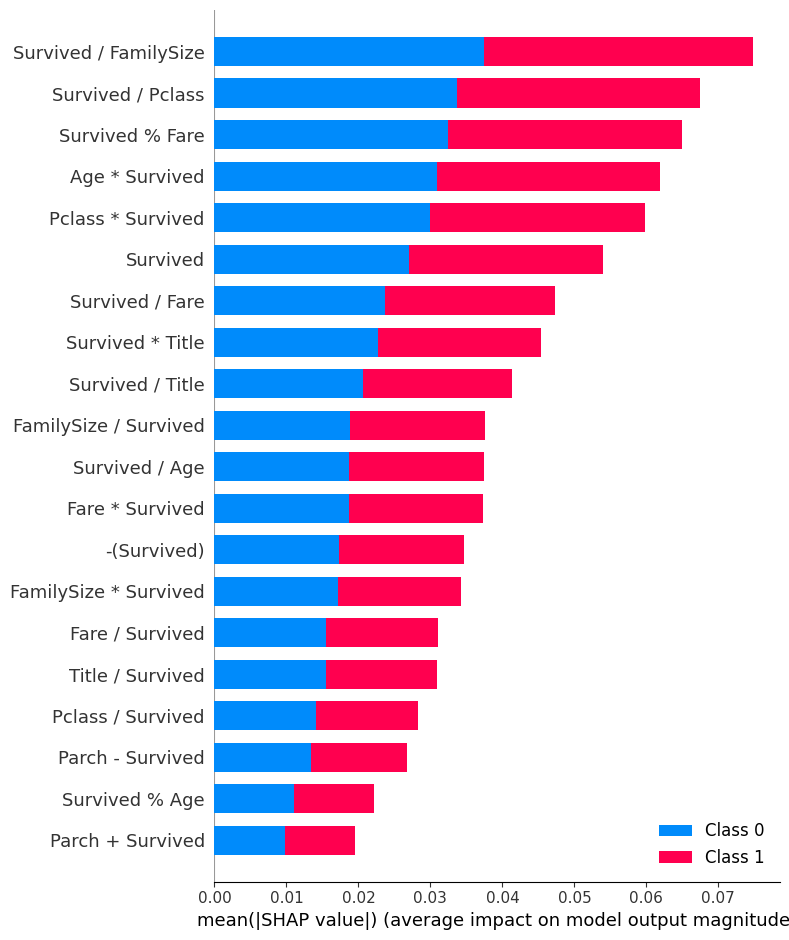

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lime.lime_tabular
import shap
import featuretools as ft
from sklearn.impute import SimpleImputer

# Load the data
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Handle missing values
def handle_missing_values(df, strategy='mean'):
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if strategy == 'mean' and pd.api.types.is_numeric_dtype(df[column]):
                df[column] = df[column].fillna(df[column].mean())
            elif strategy == 'median' and pd.api.types.is_numeric_dtype(df[column]):
                df[column] = df[column].fillna(df[column].median())
            elif strategy == 'mode':
                df[column] = df[column].fillna(df[column].mode()[0])
            elif strategy == 'drop':
                df.dropna(subset=[column], inplace=True)
    return df

train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df, strategy='median')

# Feature engineering: creating new features
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extract titles from 'Name'
for dataset in [train_df, test_df]:
    dataset['Title'] = dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in [train_df, test_df]:
    dataset['Title'] = dataset['Title'].map(title_mapping)

# Now we can remove the 'Name', 'Ticket', and 'PassengerId' columns
train_df = train_df.drop(columns=['Name', 'Ticket', 'PassengerId'])
test_df = test_df.drop(columns=['Name', 'Ticket', 'PassengerId'])

# Encoding categorical variables
def encode_categorical(df):
    return pd.get_dummies(df, drop_first=True)

train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)

# Align train and test data to have the same columns
target = train_df['Survived']  # Save the target variable
train_df, test_df = train_df.align(test_df, join='inner', axis=1)
train_df['Survived'] = target  # Reattach the target variable

# Ensure no 'PassengerId' or other non-feature columns are present
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values in the training and validation sets
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
test_df = imputer.transform(test_df)

# Rescale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_df = scaler.transform(test_df)

# Convert back to DataFrames for easier manipulation
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
test_df = pd.DataFrame(test_df, columns=X.columns)

# Interaction feature between 'Fare' and 'FamilySize'
for df in [X_train, X_val, test_df]:
    df['Fare_FamilySize'] = df['Fare'] * df['FamilySize']

# Featuretools for automated feature engineering
es = ft.EntitySet(id="titanic")
es = es.add_dataframe(dataframe_name="passengers", dataframe=train_df, index="PassengerId")

# Run deep feature synthesis with more primitives and deeper feature synthesis
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="passengers",
    trans_primitives=["multiply_numeric", "divide_numeric", "add_numeric", "subtract_numeric", "negate", "modulo_numeric"],
    agg_primitives=["mean", "sum", "min", "max", "std"],
    max_depth=2,
    verbose=True
)

# Replace infinite values and fill missing values
X = feature_matrix.replace([np.inf, -np.inf], np.nan)
X.fillna(0, inplace=True)
Y = train_df['Survived']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Rescale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Check if 'Fare' and 'FamilySize' columns exist and create interaction feature
if 'Fare' in X_train_scaled.columns and 'FamilySize' in X_train_scaled.columns:
    X_train_scaled['Fare_FamilySize'] = X_train_scaled['Fare'] * X_train_scaled['FamilySize']
    X_test_scaled['Fare_FamilySize'] = X_test_scaled['Fare'] * X_test_scaled['FamilySize']
else:
    print("'Fare' or 'FamilySize' column not found in X_train_scaled. Ensure the column exists before creating interaction features.")

# Train and evaluate models
models = {
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(Y_test, Y_pred) * 100
    results[name] = accuracy

print("Model Performance:\n", results)

# SHAP summary plot
explainer = shap.TreeExplainer(models['Random Forest'])
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar")

# LIME explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train_scaled.columns,
    class_names=['Not Survived', 'Survived'],
    mode='classification'
)

# Choose an instance to explain
i = 5
exp = explainer.explain_instance(X_test_scaled.iloc[i], models['Random Forest'].predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, Y_train)
print(CV_rfc.best_params_)

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(random_forest, X_train, Y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {cv_scores.mean()}')

{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Score: 1.0


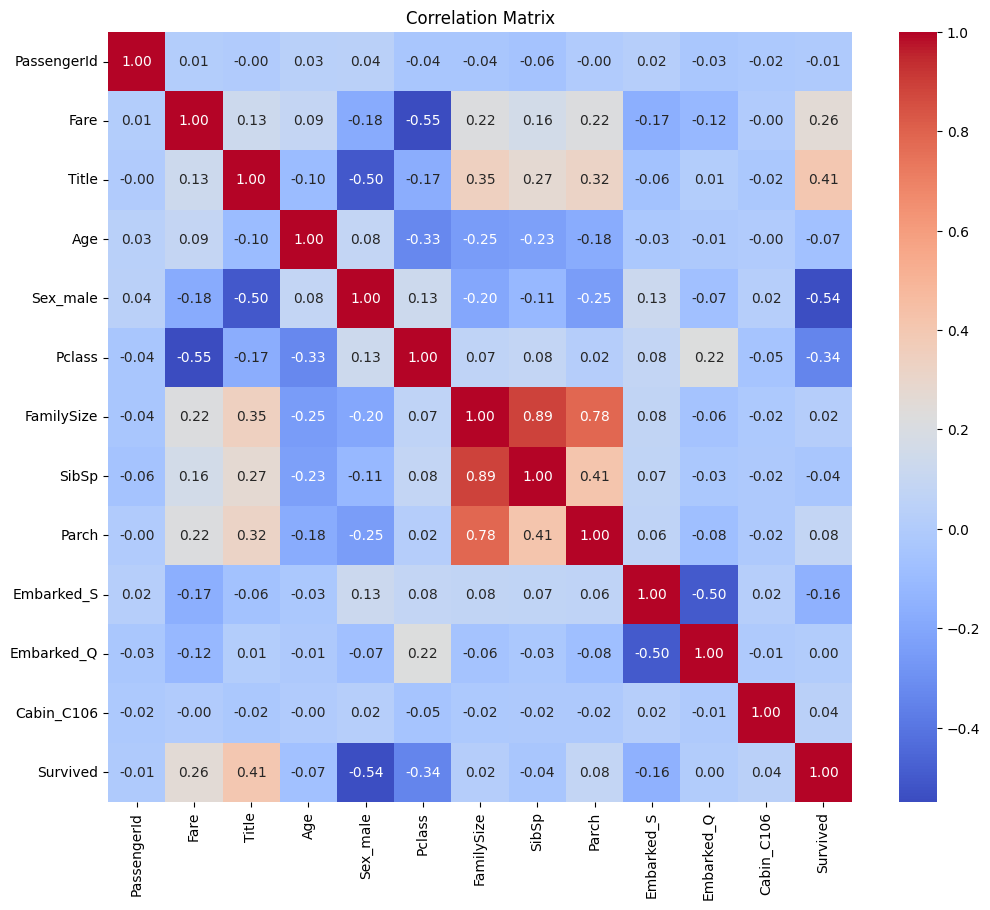

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def correlation_matrix(df, top_features, title='Correlation Matrix'):
    # Filter out features not present in df.columns
    valid_features = [feature for feature in top_features if feature in df.columns]
    
    # Select the top features based on feature importance
    corr = df[valid_features].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

# Get top 20 features based on feature importance
top_features = importance_df.head(20)['Feature'].tolist()

# Include 'Survived' for correlation matrix
top_features.append('Survived')

# Plot the correlation matrix with the top features
correlation_matrix(train_df, top_features)


In [41]:
import featuretools as ft

ft.primitives.list_primitives()

import featuretools as ft

# Save the 'Survived' column and remove it from train_df temporarily
target = feature_matrix['Survived']
feature_matrix.drop(columns=['Survived'], inplace=True)

# Align the train and test datasets
train_df, test_df = feature_matrix.align(test_df, join='inner', axis=1)

# Reattach the 'Survived' column to the training data
train_df['Survived'] = target

# Assuming train_df and test_df are already loaded and cleaned

# Create an entity set
es = ft.EntitySet(id="titanic")

# Add the dataframe as an entity
es = es.add_dataframe(dataframe_name="passengers", dataframe=train_df, index="PassengerId")

# Choose different or valid transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_dataframe_name="passengers", 
                                      trans_primitives=["multiply_numeric", "divide_numeric"])

es = ft.EntitySet(id="titanic")
es = es.add_dataframe(dataframe_name="passengers", dataframe=train_df, index="PassengerId")

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="passengers",
    trans_primitives=["multiply_numeric", "divide_numeric", "add_numeric", "subtract_numeric", "negate", "modulo_numeric"],
    agg_primitives=["mean", "sum", "min", "max", "std"],
    max_depth=2,
    verbose=True
)

# Ensure 'Survived' is still in feature_matrix after DFS
if 'Survived' not in feature_matrix.columns:
    feature_matrix['Survived'] = train_df['Survived']  # Reattach if necessary

# Assuming feature_matrix and target variable 'Survived' is in the matrix


# Model training and evaluation
def train_model(df, target):
    X = df.drop(columns=[target])
    Y = df[target]
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Check for infinite values and replace them with NaN
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Optionally, drop rows with NaN values or fill them with a specific value (e.g., the mean)
    nan_rows_X_train = X_train.isna().any(axis=1)
    X_train = X_train[~nan_rows_X_train]
    Y_train = Y_train[~nan_rows_X_train]  # Drop corresponding rows in Y_train
    
    nan_rows_X_test = X_test.isna().any(axis=1)
    X_test = X_test[~nan_rows_X_test]
    Y_test = Y_test[~nan_rows_X_test]  # Drop corresponding rows in Y_test
    
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train and evaluate models
    models = {
        'Support Vector Machine': SVC(),
        'Random Forest': RandomForestClassifier(n_estimators=100)
        # Add other models here
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred) * 100
        results[name] = accuracy
    
    return results, models['Random Forest'], scaler, X_train, X_test, Y_train, Y_test

# Assuming 'Survived' is the target column
results, random_forest, scaler, X_train, X_test, Y_train, Y_test = train_model(train_df, 'Survived')
print("Model Performance:\n", results)



index PassengerId not found in dataframe, creating new integer column
Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
Some specified primitives were not used during DFS:
  agg_primitives: ['max', 'mean', 'min', 'std', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.


Built 252 features
Elapsed: 00:00 | Progress: 100%|██████████
Model Performance:
 {'Support Vector Machine': 79.3296089385475, 'Random Forest': 85.47486033519553}


Cross-Validation Scores: [0.81118881 0.82394366 0.76056338 0.79577465 0.83098592]
Mean Cross-Validation Score: 0.8044912833645228


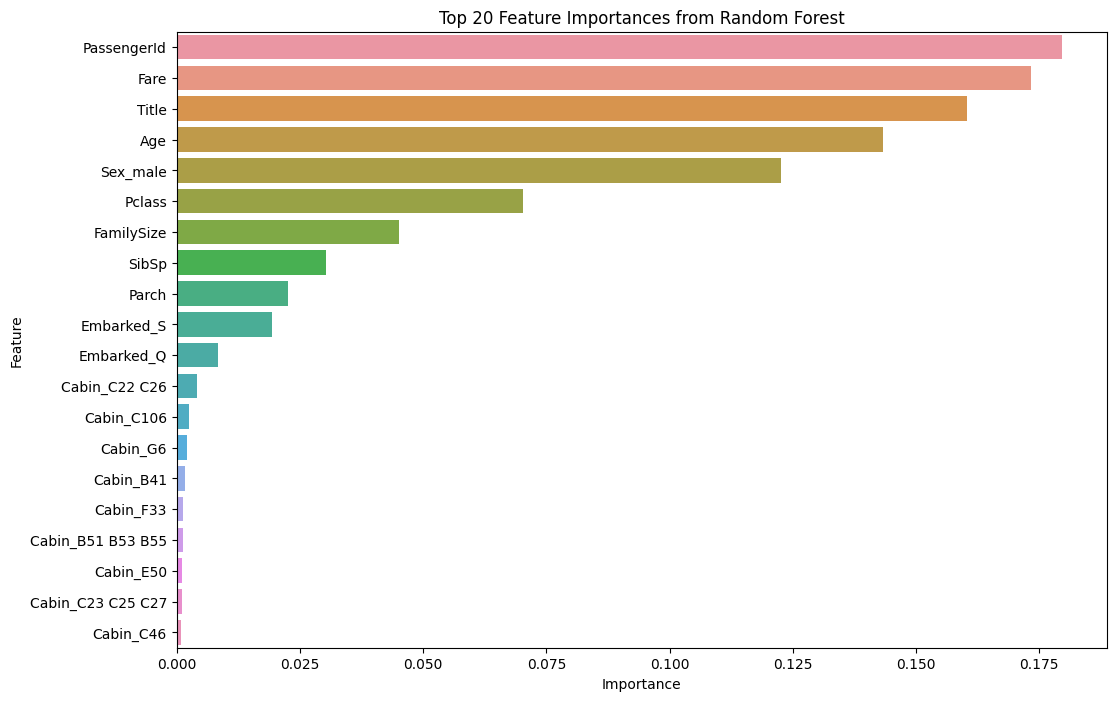

In [42]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cross-Validation
cv_scores = cross_val_score(random_forest, X_train, Y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {cv_scores.mean()}')

# Feature Importance Analysis
importances = random_forest.feature_importances_
# Use the original feature names from the dataframe
features = train_df.drop(columns=['Survived']).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Display top 20 features
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [44]:
# Assuming 'train_df' is already loaded and preprocessed

# Step 1: Define X and Y
X = train_df.drop(columns=['Survived'])
Y = train_df['Survived']

# Step 2: Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 3: Rescale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Step 5: Check if 'Fare' and 'FamilySize' columns exist and create interaction feature
if 'Fare' in X_train_scaled.columns and 'FamilySize' in X_train_scaled.columns:
    # Initialize X_train_poly_df and X_test_poly_df from X_train_scaled and X_test_scaled
    X_train_poly_df = X_train_scaled.copy()
    X_test_poly_df = X_test_scaled.copy()
    
    # Create interaction feature between 'Fare' and 'FamilySize'
    X_train_poly_df['Fare_FamilySize'] = X_train_scaled['Fare'] * X_train_scaled['FamilySize']
    X_test_poly_df['Fare_FamilySize'] = X_test_scaled['Fare'] * X_test_scaled['FamilySize']
else:
    print("'Fare' or 'FamilySize' column not found in X_train_scaled. Ensure the column exists before creating interaction features.")


In [45]:
# Step 0: Check initial columns
print("Initial columns in train_df:", train_df.columns.tolist())

# Step 1: Define X and Y
X = train_df.drop(columns=['Survived'])
Y = train_df['Survived']

# Check if 'Fare' and 'FamilySize' exist in the original X
if 'Fare' in X.columns and 'FamilySize' in X.columns:
    print("'Fare' and 'FamilySize' exist in the original X.")
else:
    print("'Fare' or 'FamilySize' is missing in the original X.")

# Step 2: Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 3: Rescale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Step 5: Check if 'Fare' and 'FamilySize' columns exist after scaling
print("Columns after scaling:", X_train_scaled.columns.tolist())

if 'Fare' in X_train_scaled.columns and 'FamilySize' in X_train_scaled.columns:
    # Initialize X_train_poly_df and X_test_poly_df from X_train_scaled and X_test_scaled
    X_train_poly_df = X_train_scaled.copy()
    X_test_poly_df = X_test_scaled.copy()
    
    # Create interaction feature between 'Fare' and 'FamilySize'
    X_train_poly_df['Fare_FamilySize'] = X_train_scaled['Fare'] * X_train_scaled['FamilySize']
    X_test_poly_df['Fare_FamilySize'] = X_test_scaled['Fare'] * X_test_scaled['FamilySize']
    print("Interaction feature 'Fare_FamilySize' created successfully.")
else:
    print("'Fare' or 'FamilySize' column not found in X_train_scaled. Ensure the column exists before creating interaction features.")


Initial columns in train_df: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Title', 'Sex_male', 'Cabin_A34', 'Cabin_B41', 'Cabin_B51 B53 B55', 'Cabin_B57 B59 B63 B66', 'Cabin_B58 B60', 'Cabin_B69', 'Cabin_B71', 'Cabin_B78', 'Cabin_C101', 'Cabin_C106', 'Cabin_C22 C26', 'Cabin_C23 C25 C27', 'Cabin_C32', 'Cabin_C46', 'Cabin_C54', 'Cabin_C62 C64', 'Cabin_C7', 'Cabin_C78', 'Cabin_C85', 'Cabin_C86', 'Cabin_D', 'Cabin_D10 D12', 'Cabin_D15', 'Cabin_D19', 'Cabin_D21', 'Cabin_D28', 'Cabin_D30', 'Cabin_D37', 'Cabin_E31', 'Cabin_E34', 'Cabin_E46', 'Cabin_E50', 'Cabin_F G63', 'Cabin_F2', 'Cabin_F33', 'Cabin_F4', 'Cabin_G6', 'Embarked_Q', 'Embarked_S', 'Survived']
'Fare' and 'FamilySize' exist in the original X.
Columns after scaling: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Title', 'Sex_male', 'Cabin_A34', 'Cabin_B41', 'Cabin_B51 B53 B55', 'Cabin_B57 B59 B63 B66', 'Cabin_B58 B60', 'Cabin_B69', 'Cabin_B71', 'Cabin_B78', 'Cabin_C101', 'Cabin

In [46]:
from sklearn.preprocessing import StandardScaler

# Drop 'PassengerId' from both train and test datasets, as it's not useful for modeling
X = train_df.drop(columns=['Survived', 'PassengerId'])
test_df = test_df.drop(columns=['PassengerId'], errors='ignore')
y = train_df['Survived']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Rescale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_df_scaled = scaler.transform(test_df)

# Convert back to DataFrames for easier manipulation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)

# Interaction feature between Fare and FamilySize
for df in [X_train_scaled, X_val_scaled, test_df_scaled]:
    df['Fare_FamilySize'] = df['Fare'] * df['FamilySize']



In [47]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Impute missing values
imputer = SimpleImputer(strategy='mean', add_indicator=True)  # add_indicator=True if you suspect extra indicator columns
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_val_scaled_imputed = imputer.transform(X_val_scaled)

# Print feature names after imputation to diagnose the issue
print("Shape of X_train_scaled_imputed after imputation:", X_train_scaled_imputed.shape)

# Check the new feature names introduced by the imputation
if isinstance(X_train_scaled_imputed, pd.DataFrame):
    print("Features after imputation:", X_train_scaled_imputed.columns.tolist())

# If an extra feature is detected, identify and remove it
if X_train_scaled_imputed.shape[1] > X_train.columns.shape[0]:
    extra_feature_index = X_train_scaled_imputed.shape[1] - X_train.columns.shape[0]
    print(f"Extra feature detected at index {extra_feature_index}")
    X_train_scaled_imputed = X_train_scaled_imputed[:, :-extra_feature_index]  # Remove the extra feature
    X_val_scaled_imputed = X_val_scaled_imputed[:, :-extra_feature_index]

# Ensure consistency in feature numbers
if X_train_scaled_imputed.shape[1] != X_train.columns.shape[0]:
    raise ValueError(f"Feature mismatch: Expected {X_train.columns.shape[0]} features, but got {X_train_scaled_imputed.shape[1]}.")

# Apply polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled_imputed)
X_val_poly = poly.transform(X_val_scaled_imputed)

# Convert back to DataFrame with appropriate feature names
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns))
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly.get_feature_names_out(X_val.columns))

# Print the final feature names after applying polynomial features
print("Final feature names after polynomial features:", X_train_poly_df.columns.tolist())


Shape of X_train_scaled_imputed after imputation: (712, 49)
Extra feature detected at index 2
Final feature names after polynomial features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Title', 'Sex_male', 'Cabin_A34', 'Cabin_B41', 'Cabin_B51 B53 B55', 'Cabin_B57 B59 B63 B66', 'Cabin_B58 B60', 'Cabin_B69', 'Cabin_B71', 'Cabin_B78', 'Cabin_C101', 'Cabin_C106', 'Cabin_C22 C26', 'Cabin_C23 C25 C27', 'Cabin_C32', 'Cabin_C46', 'Cabin_C54', 'Cabin_C62 C64', 'Cabin_C7', 'Cabin_C78', 'Cabin_C85', 'Cabin_C86', 'Cabin_D', 'Cabin_D10 D12', 'Cabin_D15', 'Cabin_D19', 'Cabin_D21', 'Cabin_D28', 'Cabin_D30', 'Cabin_D37', 'Cabin_E31', 'Cabin_E34', 'Cabin_E46', 'Cabin_E50', 'Cabin_F G63', 'Cabin_F2', 'Cabin_F33', 'Cabin_F4', 'Cabin_G6', 'Embarked_Q', 'Embarked_S', 'Pclass Age', 'Pclass SibSp', 'Pclass Parch', 'Pclass Fare', 'Pclass FamilySize', 'Pclass Title', 'Pclass Sex_male', 'Pclass Cabin_A34', 'Pclass Cabin_B41', 'Pclass Cabin_B51 B53 B55', 'Pclass Cabin_B57 B59 B63 B66', 'Pclass Cabi

In [48]:
import joblib

# Function to save a model
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# Function to load a model
def load_model(filename):
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

In [49]:
def preprocess_new_data(df, scaler, add_interactions=False):
    # Drop any columns not used in training, such as PassengerId
    if 'PassengerId' in df.columns:
        df = df.drop(columns=['PassengerId'])
    
    # Scale the data
    df_scaled = scaler.transform(df)

    # Convert back to DataFrame for easier manipulation
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Add interaction features if specified
    if add_interactions:
        df_scaled['Fare_FamilySize'] = df_scaled['Fare'] * df_scaled['FamilySize']

    return df_scaled

# Assuming you have a trained scaler and model
unseen_test_df = pd.read_csv('/kaggle/input/titanic/test.csv')  # Load your unseen test data
unseen_test_df, _ = unseen_test_df.align(train_df.drop(columns=['Survived']), join='right', axis=1)

# Re-scale and add interaction features
unseen_test_df_scaled = preprocess_new_data(unseen_test_df, scaler, add_interactions=True)

# Final check for any NaN values
if unseen_test_df_scaled.isnull().values.any():
    unseen_test_df_scaled.fillna(0, inplace=True)  # Fill NaN values if any

# Now you can use the trained model to make predictions
predictions = random_forest.predict(unseen_test_df_scaled)


X has feature names, but RandomForestClassifier was fitted without feature names


In [50]:
# Print the first few predictions
print("First 10 predictions:")
print(Y_pred[:10])

# Check the submission DataFrame
print("First few rows of the submission:")
print(submission.head())


First 10 predictions:
[1 0 0 1 1 1 1 0 1 1]
First few rows of the submission:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [51]:
# Use the first row of X_test_poly_df to make a prediction
X_sample = X_test_poly_df.iloc[[0]].copy()  # Select the first row as a sample input

# Remove the 'PassengerId' column
if 'PassengerId' in X_sample.columns:
    X_sample = X_sample.drop(columns=['PassengerId'])

# Ensure the sample input is correctly formatted
X_sample = X_sample.values  # Convert to the format required by the model

# Make a prediction using the trained Random Forest model
prediction = random_forest.predict(X_sample)

# Output the prediction
print(f"Prediction for the sample input: {prediction[0]}")


Prediction for the sample input: 0


In [52]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest model
model = RandomForestClassifier(random_state=42)

# Initialize RFE with the model
selector = RFE(estimator=model, n_features_to_select=10, step=1)

# Fit RFE on the polynomial features
selector = selector.fit(X_train_poly_df, y_train)

# Get selected features
selected_features = X_train_poly_df.columns[selector.support_]

# Reduce the training and validation sets to selected features
X_train_selected = X_train_poly_df[selected_features]
X_val_selected = X_val_poly_df[selected_features]


In [55]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Assuming X_train_poly_df is your DataFrame
# Initialize the imputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent', etc.

# Fit and transform the training data
X_train_imputed = imputer.fit_transform(X_train_poly_df)

# Convert the imputed data back to a DataFrame
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train_poly_df.columns)

# You can now apply PCA or any other model
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_imputed_df)

# If you're using this in RFE or another model:
# model = RandomForestClassifier(random_state=42)
# selector = RFE(estimator=model, n_features_to_select=10, step=1)
# selector.fit(X_train_imputed_df, y_train)


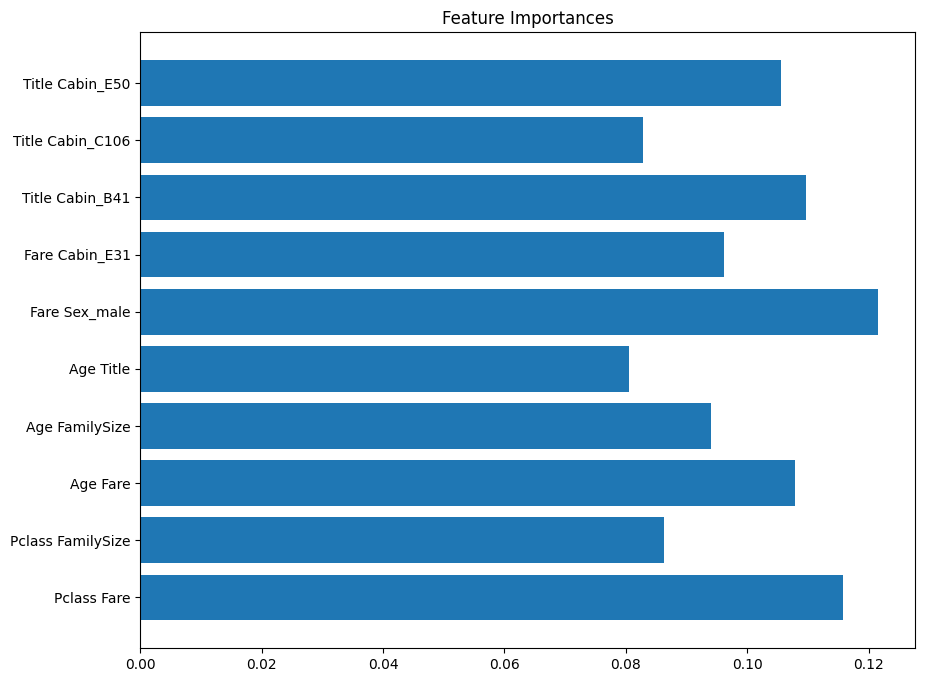

In [56]:
import matplotlib.pyplot as plt

# Fit the model on the selected features
model.fit(X_train_selected, y_train)

# Get feature importances
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(selected_features, importances)
plt.title("Feature Importances")
plt.show()


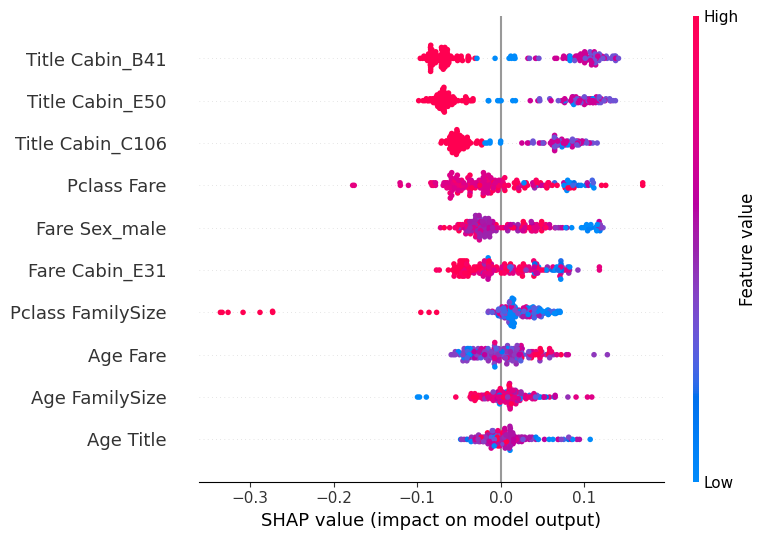

In [57]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val_selected)

# Plot summary
shap.summary_plot(shap_values[1], X_val_selected)


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Load your training data
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Feature engineering (as per your previous steps)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Drop irrelevant columns
X = train_df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket'])  # Dropping target and irrelevant columns
y = train_df['Survived']  # This is your target variable

# Encode categorical variables (like 'Sex' and 'Embarked')
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Rescale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Save the scaler to the current directory
joblib.dump(scaler, 'scaler.pkl')

# Continue with model training or any further processing


['scaler.pkl']